# Approach
1. Clean data
2. Split with customer with solar panels not installed with Zonneplan (category_1) and the others (category_2)
3. For category_2: 
    * set pv to 0 when NaN
    * consumption = p1 + pv
4. For category_1:
    * infer pv_forecast: average the pv of category_2 at a given time --> pv_avg
    * infer the consumption of category_1: consumption = p1 + pv_avg
5. Train the data
6. Test the model
    * Infer the consumption of each household
    * Compare with the results by comparing to p1

# Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# Load Data

In [2]:
contracts = pd.read_csv('datafiles_assignment_data_scientist/contracten_database_table.csv', sep = ';')
data = pd.read_json('datafiles_assignment_data_scientist/actual_values.json')
forecast_values = pd.read_json('datafiles_assignment_data_scientist/forecast_values.json')
weather_actual = pd.read_json('datafiles_assignment_data_scientist/weather_actual.json')
weather_forecast = pd.read_json('datafiles_assignment_data_scientist/weather_forecast.json')
prices = pd.read_json('datafiles_assignment_data_scientist/price_epex.json')

# Data Preprocessing
## Data cleaning
Remove outliers using threshold defined in EDA.

In [3]:
# remove outlier
threshold = 5*10e3
data = data[(data.p1_actual_kwh > -threshold) & (data.p1_actual_kwh < threshold)].copy()

## Split: with solar panels from/not from Zonneplan

In [4]:
# Set of contract_id having solar panels with Zonneplan (based of pv_actual_kwh)
pv_w_zp_contract = set(data[~data['pv_actual_kwh'].isnull()]['contract_id'])

# (Inferred) Set of contract_id having solar panel not with Zonneplan
# To do so, we assume that contract_id with p1_actual_kwh < 0 have solar panels
customer_w_pv = set(data[data['p1_actual_kwh'] < 0]['contract_id'])
pv_wo_zp_contract = customer_w_pv - pv_w_zp_contract

In [5]:
# Add column to indicate if the household has solar panels NOT installed by Zonneplan (1 if True, 0 otherwise)
data['not_ZP_pv'] = data.apply(lambda row : 1 if row.contract_id in pv_wo_zp_contract else 0, axis = 1)

In [6]:
# Add column to indicate if the customer has solar panels
data['has_pv'] = data.apply(lambda row : 1 if row.contract_id in customer_w_pv else 0, axis = 1)

## Handling of missing values
Set to 0 Nan of p1_actual_kwh

In [7]:
data['pv_actual_kwh'] = data['pv_actual_kwh'].replace(np.nan, 0)

### Split: Training and Test

In [8]:
date_split = data.timestamp.min() + timedelta(days=20)

In [9]:
train_data = data[data.timestamp < date_split].copy()
test_data = data[data.timestamp >= date_split].copy()

In [10]:
# Remove pv_actual_kwh and p1_actual_kwh from test
#test_data.drop(['p1_actual_kwh', 'pv_actual_kwh'], axis = 1, inplace = True)

## Feature selection

Consumption:
* for customers with solar panels installed by Zonneplan: p1_actual_kwh + pv_actual_kwh (or pv_forecast_kwh for test data)
* for customers with solar panels not installed by Zonneplan: get the averaged pv_actual_kwh/pv_forecast_kwh an add it to the p1_actual_pwh

In [11]:
# Average solar power production on train data
train_pv_avg = train_data[(train_data['not_ZP_pv'] == 0) & \
                          (train_data['has_pv'] == 1)].groupby('timestamp')['pv_actual_kwh'].mean()

In [12]:
# Deduce consumption
train_data['consumption'] = train_data.apply(lambda row : row['p1_actual_kwh'] + train_pv_avg[row['timestamp']] \
                                             if row['not_ZP_pv'] == 1 \
                                             else row['p1_actual_kwh'] + row['pv_actual_kwh'], 
                                             axis = 1)

In [13]:
train_data.head()

,contract_id,timestamp,pv_actual_kwh,p1_actual_kwh,pv_forecast_kwh,not_ZP_pv,has_pv,consumption
768,105587,2022-12-09 00:00:00,0.0,67.0,0.0,0,1,67.0
769,105587,2022-12-09 00:15:00,0.0,78.0,0.0,0,1,78.0
770,105587,2022-12-09 00:30:00,0.0,59.0,0.0,0,1,59.0
771,105587,2022-12-09 00:45:00,0.0,60.0,0.0,0,1,60.0
772,105587,2022-12-09 01:00:00,0.0,84.0,0.0,0,1,84.0


# Training Forecast
**Methods:**
* Naive methods: Average previous consumption off all households together by considering feature like time
* Conidering additional pv input: Predict the solar production for household with solar without Zonneplan
* fine-tune per customer: create model per customer

In [14]:
# Get the average consumption of all household at given hour
def consumption_avg_all(data):
    '''
    Get the average consumption of all household at given time.
    Input: 
        - data: DataFrame with at least the following columns: contract_id, timestamp, consumption
    Return:
        - DataFrame with the average consumption of all household per hour of the day
    '''
    return data.groupby(data['timestamp'].dt.hour)['consumption'].mean()

In [15]:
# Get the average consumption per contract at given hour
def consumption_avg_per_contract(data):
    '''
    Get the average consumption of per household at given time.
    Input: 
        - data: DataFrame with at least the following columns: contract_id, timestamp, consumption
    Return:
        - DataFrame with the average consumption per household per hour of the day
    '''
    return data.groupby(['contract_id', data['timestamp'].dt.hour])['consumption'].mean()

# Test

In [16]:
# Generate list the pv_forecast for customer with solar panels non installed by Zonneplan
# By average the pv_forecast at a given time
def generalize_pv_forecast(data):
    # Average the pv_forecast at a given time
    pv_avg = data[(data['not_ZP_pv'] == 0) & (data['has_pv'] == 1)].groupby('timestamp')['pv_forecast_kwh'].mean()
    
    # Add the pv_avg to where not_zp_pv = 1
    data['pv_forecast_kwh'] = data.apply(lambda row: pv_avg[row['timestamp']] if row['not_ZP_pv'] == 1 \
                                         else row['pv_forecast_kwh'], axis=1)

In [17]:
generalize_pv_forecast(test_data)

In [18]:
# Forecast consumption using basic approach: the consumption is inferred by averaging the hourly the consumption of 
# all household
def forecast_cons_avg_all(data):
    cons_avg_all = consumption_avg_all(train_data)
    data['cons_forecast_avg_all'] = data.apply(lambda row: cons_avg_all[row.timestamp.hour], axis = 1)

In [19]:
forecast_cons_avg_all(test_data)

In [20]:
# Forecast consumption using approach: the consumption is inferred by averaging the hourly the consumption of 
# of a given household. In the household is new (new contract in test data), the consumption is inferred by
# using the averaged of all households
def forecast_cons_avg_individual(data):
    cons_avg_all = consumption_avg_all(train_data)
    cons_avg_ind = consumption_avg_per_contract(train_data)
    
    # contract_id in the train data
    train_contract_id = cons_avg_ind.index.get_level_values('contract_id').unique()
    data['cons_forecast_avg_ind'] = data.apply(lambda row: cons_avg_ind[row['contract_id']][row.timestamp.hour]  \
                                               if row['contract_id'] in train_contract_id \
                                               else cons_avg_all[row.timestamp.hour], axis = 1)

In [21]:
forecast_cons_avg_individual(test_data)

In [22]:
# Deduce the forecast of p1 using the different approaches
test_data['p1_forecast_avg_all'] = test_data['cons_forecast_avg_all'] - test_data['pv_forecast_kwh']
test_data['p1_forecast_avg_ind'] = test_data['cons_forecast_avg_ind'] - test_data['pv_forecast_kwh']

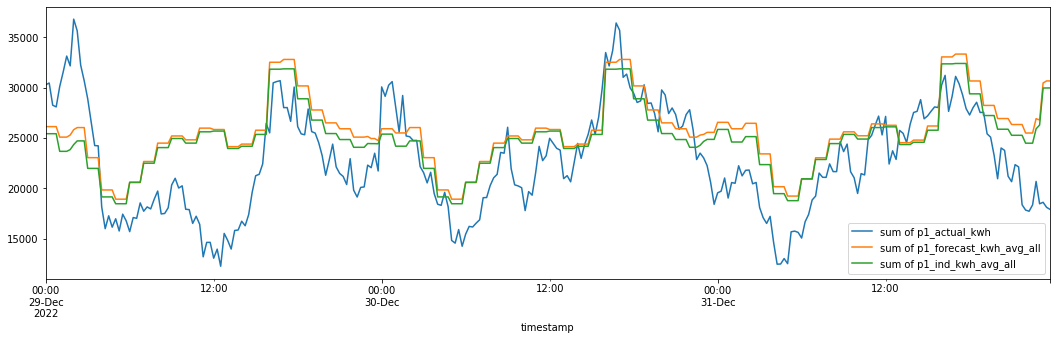

In [23]:
fig, ax = plt.subplots(figsize=(18,5))
test_data.groupby(test_data.timestamp)['p1_actual_kwh'].sum().plot(label = 'sum of p1_actual_kwh')
test_data.groupby(test_data.timestamp)['cons_forecast_avg_all'].sum().plot(label='sum of p1_forecast_kwh_avg_all', \
                                                                           ax=ax)
test_data.groupby(test_data.timestamp)['cons_forecast_avg_ind'].sum().plot(label='sum of p1_ind_kwh_avg_all', \
                                                                           ax=ax)
plt.legend()

In [24]:
test_data[(test_data['not_ZP_pv'] == 1) & (test_data.timestamp.dt.hour == 12)]

,contract_id,timestamp,pv_actual_kwh,p1_actual_kwh,pv_forecast_kwh,not_ZP_pv,has_pv,cons_forecast_avg_all,cons_forecast_avg_ind,p1_forecast_avg_all,p1_forecast_avg_ind
142076,99503,2022-12-29 12:00:00,0.0,326.0,122.228814,1,1,210.065081,583.319105,87.836267,461.090291
142077,99503,2022-12-29 12:15:00,0.0,474.0,119.949153,1,1,210.065081,583.319105,90.115928,463.369952
142078,99503,2022-12-29 12:30:00,0.0,768.0,112.576271,1,1,210.065081,583.319105,97.488809,470.742834
142079,99503,2022-12-29 12:45:00,0.0,1200.0,110.516949,1,1,210.065081,583.319105,99.548131,472.802156
142242,100788,2022-12-29 12:00:00,0.0,-129.0,122.228814,1,1,210.065081,27.056605,87.836267,-95.172209
...,...,...,...,...,...,...,...,...,...,...,...
282323,139863,2022-12-30 12:45:00,0.0,76.0,82.262712,1,1,210.065081,305.259569,127.802369,222.996857
282422,139863,2022-12-31 12:00:00,0.0,746.0,69.161017,1,1,210.065081,305.259569,140.904064,236.098552
282423,139863,2022-12-31 12:15:00,0.0,520.0,69.161017,1,1,210.065081,305.259569,140.904064,236.098552
282424,139863,2022-12-31 12:30:00,0.0,342.0,63.974576,1,1,210.065081,305.259569,146.090504,241.284992


# Forecast period January 1 to 7

In [26]:
# Add column to indicate if the household has solar panels NOT installed by Zonneplan (1 if True, 0 otherwise)
forecast_values['not_ZP_pv'] = forecast_values.apply(lambda row : 1 \
                                                     if row.contract_id in pv_wo_zp_contract else 0, axis = 1)

# Add column to indicate if the customer has solar panels
forecast_values['has_pv'] = forecast_values.apply(lambda row : 1 if row.contract_id in customer_w_pv else 0, axis = 1)

In [27]:
generalize_pv_forecast(forecast_values)

In [28]:
forecast_cons_avg_all(forecast_values)

In [29]:
forecast_cons_avg_individual(forecast_values)

In [30]:
forecast_values

,contract_id,timestamp,pv_forecast_kwh,not_ZP_pv,has_pv,cons_forecast_avg_all,cons_forecast_avg_ind
0,142828,2023-01-01 00:00:00,0.0,0,0,212.423135,55.166667
1,142828,2023-01-01 00:15:00,0.0,0,0,212.423135,55.166667
2,142828,2023-01-01 00:30:00,0.0,0,0,212.423135,55.166667
3,142828,2023-01-01 00:45:00,0.0,0,0,212.423135,55.166667
4,142828,2023-01-01 01:00:00,0.0,0,0,207.305734,45.791667
...,...,...,...,...,...,...,...
102555,143050,2023-01-07 22:45:00,0.0,0,0,203.928930,40.520000
102556,143050,2023-01-07 23:00:00,NaN,0,0,204.444924,15.642857
102557,143050,2023-01-07 23:15:00,NaN,0,0,204.444924,15.642857
102558,143050,2023-01-07 23:30:00,NaN,0,0,204.444924,15.642857


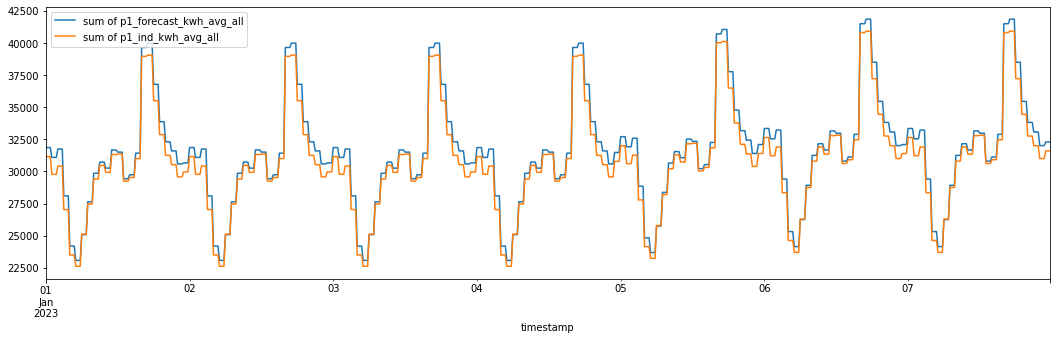

In [31]:
fig, ax = plt.subplots(figsize=(18,5))
forecast_values.groupby(forecast_values.timestamp)['cons_forecast_avg_all'].sum().plot(label='sum of p1_forecast_kwh_avg_all', \
                                                                           ax=ax)
forecast_values.groupby(forecast_values.timestamp)['cons_forecast_avg_ind'].sum().plot(label='sum of p1_ind_kwh_avg_all', \
                                                                           ax=ax)
plt.legend()

# Challenges
* Combination of households with solar panels installed by Zonneplan and not with Zonneplan: some household have energy sources we are not aware of. They can be identified by having negative values of consumption.
* Limited available data: only 3 weeks of data available

To improve this prediction in the coming months, I would continue to **collect and analyze historical data and update our models** accordingly. 

I would also **explore other forecasting methods**, such as the Prophet model developed by Facebook, and machine learning techniques, such as Linear regression, Decision tree regression, Random forest regression, ARIMA...

I would also classify the **households with/without solar panels** and try to get more data about the households with soalr panels which have not been installed by Zonneplan.

Another area for improvement is the **incorporation of external factors that could impact consumption**, such as holidays, events, changes in government policies, locations (so we can better analys the relation with the weather). By including these factors in our forecasting models, we can create more accurate and robust predictions for our energy portfolio.

One aspect that could have been better is the data cleaning and preprocessing. There were some missing values and inconsistencies in the data that needed to be addressed before we could create an accurate forecast. In the future, I would need to ensure that we have clean and consistent data before proceeding with the forecasting process.

Finally, it may be worth to look at other datasets online such as Kaggle (for instance: [Energy consumption of the Netherlands](https://www.kaggle.com/datasets/lucabasa/dutch-energy))